## Project 3 - Part 2
For this phase of the project, you will be helping Chicago law enforcement allocate resources for the next 6 months.

You will compare the crime count forecast for 2 of the options below:

* Theft
* Battery
* Narcotics
* Assault
* Total Crime (sum of all crime types).

#### For each of your selected crimes, perform the following steps to develop a forecast.

* Transform the data to obtain a time series of the crime count per month using .size().
* Check for and address null values.
* Decompose the Time series to detect seasonality and decide whether to use a seasonal model or not
* Determine if nonseasonal and/or seasonal differencing is required
* Use the ACF and PACF plots of stationarity data to estimate initial orders
* Split the time series into training and test data (Remember we want to predict 6 months)
* Fit a manual ARIMA/SARIMA model based on the orders determined during your exploration.
    * Make forecasts with your model.
    * Plot the forecasts versus the test data
    * Obtain metrics for evaluation
* Tune with pmdarima's auto_arima
    * Fit a model on training data with the best parameters from auto_arima
    * Obtain metrics for evaluation
    * Make forecasts with the auto_arima model
    * Plot the forecasts versus the test data
* Select the final model and justify your choice. (Which metrics or diagnostics support your choice?)
* Make true future forecasts using the entire dataset (for dates beyond the entire ts)

#### For each of your two selected crimes, answer the following questions in a markdown cell:

* Calculate the predicted net change in the number (raw counts) of this type of crime from the beginning of the forecast to the end.
* Convert the raw delta into a percent change.

#### Final Evaluation:

After completing both models and getting the forecasts for both crimes for 6 months into the future (beyond the data), answer the following questions in a Markdown cell:

* Of the two crimes, which is forecasted to have the highest monthly count of crimes at the end of the forecast?
* Of the two crimes, which is forecasted to have the highest net change by the end of the forecast?
* Of the two crimes, which is forecasted to have the highest percent change by the end of the forecast?

#### Final Recommendations

* What recommendation would you make to the stakeholders?
* Include reporting-quality visual(s) to support your recommendation.

## Previous Assignment: Part 1

In [1]:
# install one time
# !pip install holidays

In [2]:
# imports
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import holidays
import datetime as dt
from holidays import country_holidays

In [3]:
# Set options
pd.set_option('display.max_columns',100)
# Customize figure style for stakeholder-facing visualizations
plt.style.use(('ggplot','fivethirtyeight'))
sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

### Load the Data

In [4]:
folder = r"C:\Users\bandi\Data\Chicago\\"
crime_files = sorted(glob.glob(folder+"*.csv"))
df = pd.concat([pd.read_csv(f) for f in crime_files])
df

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1326041,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
1,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2,1324743,01/01/2001 01:00:00 PM,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
3,1310717,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
4,1318099,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020
...,...,...,...,...,...,...,...,...,...,...,...,...
238853,12938029,12/31/2022 12:50:00 PM,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
238854,12937822,12/31/2022 12:50:00 PM,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
238855,12937583,12/31/2022 12:52:00 AM,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098
238856,12938420,12/31/2022 12:52:00 PM,ASSAULT,SIMPLE,COMMERCIAL / BUSINESS OFFICE,False,False,1432,14.0,32.0,41.930693,-87.685657


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7713109 entries, 0 to 238857
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Date                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   Ward                  float64
 10  Latitude              float64
 11  Longitude             float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 662.0+ MB


In [6]:
chicago_df = df.copy()
chicago_df

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1326041,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
1,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2,1324743,01/01/2001 01:00:00 PM,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
3,1310717,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
4,1318099,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020
...,...,...,...,...,...,...,...,...,...,...,...,...
238853,12938029,12/31/2022 12:50:00 PM,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
238854,12937822,12/31/2022 12:50:00 PM,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
238855,12937583,12/31/2022 12:52:00 AM,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098
238856,12938420,12/31/2022 12:52:00 PM,ASSAULT,SIMPLE,COMMERCIAL / BUSINESS OFFICE,False,False,1432,14.0,32.0,41.930693,-87.685657


### Convert the date column to datetime dtype

In [7]:
chicago_df['Date'] = pd.to_datetime(chicago_df['Date'], format='%m/%d/%Y %I:%M:%S %p')
chicago_df['Date']

0        2001-01-01 01:00:00
1        2001-01-01 13:00:00
2        2001-01-01 13:00:00
3        2001-01-01 01:00:00
4        2001-01-01 01:00:00
                 ...        
238853   2022-12-31 12:50:00
238854   2022-12-31 12:50:00
238855   2022-12-31 00:52:00
238856   2022-12-31 12:52:00
238857   2022-12-31 12:59:00
Name: Date, Length: 7713109, dtype: datetime64[ns]

In [8]:
chicago_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7713109 entries, 0 to 238857
Data columns (total 12 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ID                    int64         
 1   Date                  datetime64[ns]
 2   Primary Type          object        
 3   Description           object        
 4   Location Description  object        
 5   Arrest                bool          
 6   Domestic              bool          
 7   Beat                  int64         
 8   District              float64       
 9   Ward                  float64       
 10  Latitude              float64       
 11  Longitude             float64       
dtypes: bool(2), datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 662.0+ MB


In [9]:
chicago_df = chicago_df.set_index('Date')
chicago_df

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
Date,,,,,,,,,,,
2001-01-01 01:00:00,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
2001-01-01 13:00:00,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2001-01-01 13:00:00,1324743,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
2001-01-01 01:00:00,1310717,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
2001-01-01 01:00:00,1318099,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 12:50:00,12938029,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
2022-12-31 12:50:00,12937822,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
2022-12-31 00:52:00,12937583,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098


In [10]:
chicago_df.index

DatetimeIndex(['2001-01-01 01:00:00', '2001-01-01 13:00:00',
               '2001-01-01 13:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               ...
               '2022-12-31 12:41:00', '2022-12-31 00:42:00',
               '2022-12-31 00:44:00', '2022-12-31 00:45:00',
               '2022-12-31 12:45:00', '2022-12-31 12:50:00',
               '2022-12-31 12:50:00', '2022-12-31 00:52:00',
               '2022-12-31 12:52:00', '2022-12-31 12:59:00'],
              dtype='datetime64[ns]', name='Date', length=7713109, freq=None)

In [11]:
## Inspect the value_counts for the different types of crimes
crime_counts = chicago_df['Primary Type'].value_counts().to_frame('Total # of Crimes')
crime_counts

,Total # of Crimes
Primary Type,
THEFT,1626992
BATTERY,1410889
CRIMINAL DAMAGE,878914
NARCOTICS,746155
ASSAULT,501103
OTHER OFFENSE,479174
BURGLARY,422246
MOTOR VEHICLE THEFT,366586
DECEPTIVE PRACTICE,340958


In [12]:
# create a date (no time) as column
chicago_df['Date'] = chicago_df.index.date
chicago_df.head(3)

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,Date
Date,,,,,,,,,,,,
2001-01-01 01:00:00,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185,2001-01-01
2001-01-01 13:00:00,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841,2001-01-01
2001-01-01 13:00:00,1324743,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970,2001-01-01


In [13]:
# create a year column
chicago_df['Year'] = chicago_df.index.year
chicago_df.head(3)

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,Date,Year
Date,,,,,,,,,,,,,
2001-01-01 01:00:00,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185,2001-01-01,2001
2001-01-01 13:00:00,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841,2001-01-01,2001
2001-01-01 13:00:00,1324743,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970,2001-01-01,2001


In [14]:
# extracting the month
chicago_df['Month'] = chicago_df.index.month
chicago_df['MonthName'] = chicago_df.index.month_name()
chicago_df.head(3)

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,Date,Year,Month,MonthName
Date,,,,,,,,,,,,,,,
2001-01-01 01:00:00,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185,2001-01-01,2001,1,January
2001-01-01 13:00:00,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841,2001-01-01,2001,1,January
2001-01-01 13:00:00,1324743,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970,2001-01-01,2001,1,January


In [15]:
# saving lookup for number vs name
unique_months = chicago_df.drop_duplicates(subset=['Month']).sort_values('Month')
month_lookup =dict(zip(unique_months['Month'],unique_months['MonthName']))
month_lookup

{1: 'January',
 2: 'February',
 3: 'March',
 4: 'April',
 5: 'May',
 6: 'June',
 7: 'July',
 8: 'August',
 9: 'September',
 10: 'October',
 11: 'November',
 12: 'December'}

In [16]:
## adding day of week as both number & name
chicago_df['DayOfWeek'] = chicago_df.index.day_name()
chicago_df['DayNum'] = chicago_df.index.day_of_week
chicago_df.head(3)

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,Date,Year,Month,MonthName,DayOfWeek,DayNum
Date,,,,,,,,,,,,,,,,,
2001-01-01 01:00:00,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185,2001-01-01,2001,1,January,Monday,0
2001-01-01 13:00:00,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841,2001-01-01,2001,1,January,Monday,0
2001-01-01 13:00:00,1324743,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970,2001-01-01,2001,1,January,Monday,0


In [17]:
# saving lookup for number vs named days
unique_days = chicago_df.drop_duplicates(subset=['DayNum']).sort_values('DayNum')
day_lookup =dict(zip(unique_days['DayNum'],unique_days['DayOfWeek']))
day_lookup

{0: 'Monday',
 1: 'Tuesday',
 2: 'Wednesday',
 3: 'Thursday',
 4: 'Friday',
 5: 'Saturday',
 6: 'Sunday'}

In [18]:
# adding hour of the day (12am=0) 
chicago_df['HourOfDay'] = chicago_df.index.hour 
chicago_df.head(3)

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,Date,Year,Month,MonthName,DayOfWeek,DayNum,HourOfDay
Date,,,,,,,,,,,,,,,,,,
2001-01-01 01:00:00,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185,2001-01-01,2001,1,January,Monday,0,1
2001-01-01 13:00:00,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841,2001-01-01,2001,1,January,Monday,0,13
2001-01-01 13:00:00,1324743,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970,2001-01-01,2001,1,January,Monday,0,13


 ### Topic 1) Comparing Police Districts
* Which district had the most crimes in 2022?
* Which had the least?

In [19]:
# Crime counts by district for 2022
district_crimes_2022 = chicago_df.loc['2022'].groupby('District').size().sort_values(ascending=False)

In [20]:
# District with the most crimes
most_crimes_district = district_crimes_2022.idxmax()
most_crimes_district

8.0

In [21]:
# District with the least crimes
least_crimes_district = district_crimes_2022.idxmin()
least_crimes_district

31.0

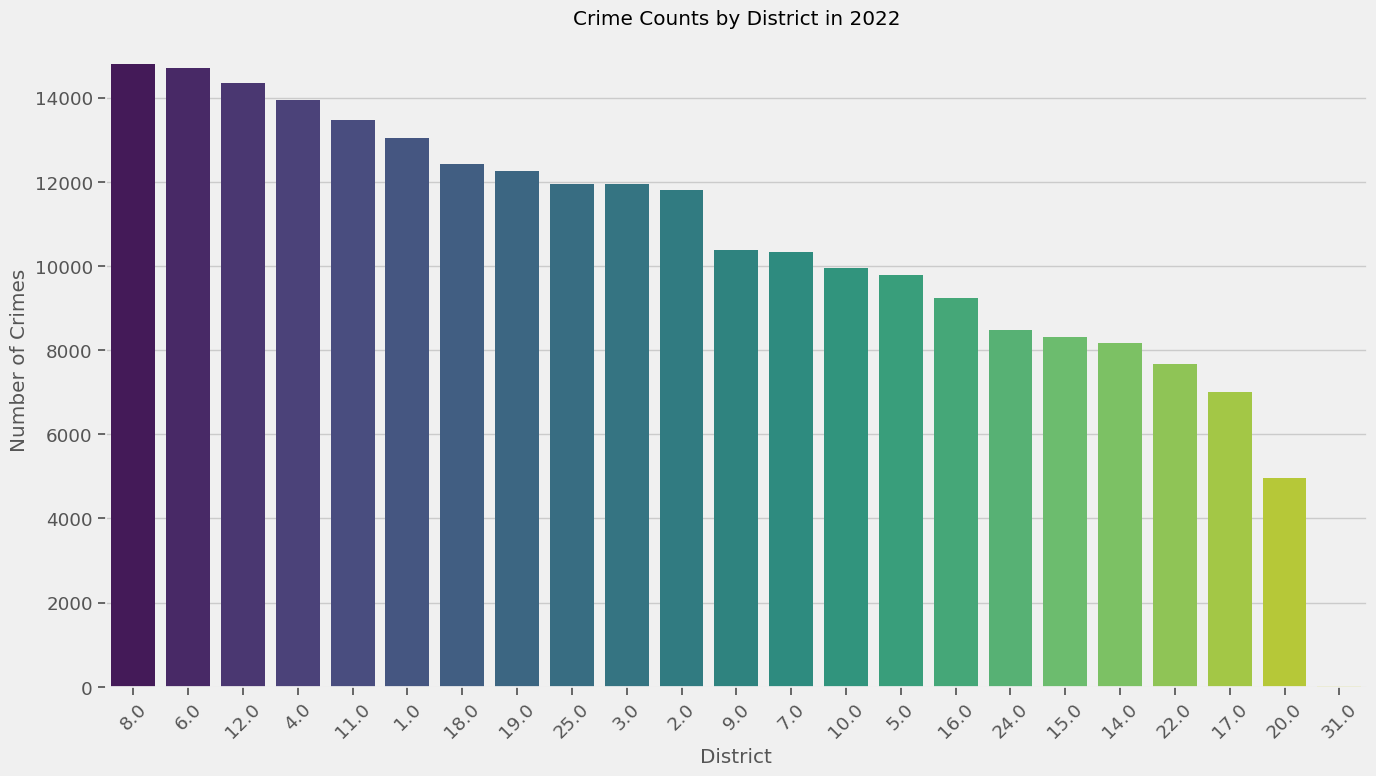

In [22]:
# Filtering the DataFrame for the year 2022
df_2022 = chicago_df.loc['2022']

# Visualization
plt.figure(figsize=(14, 8))
ax = sns.countplot(x='District', data=df_2022, palette='viridis', order = df_2022['District'].value_counts().index)
ax.set_title('Crime Counts by District in 2022')
ax.set_xlabel('District')
ax.set_ylabel('Number of Crimes')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

### Topic 3) Comparing AM vs. PM Rush Hour:
* Are crimes more common during AM rush hour or PM rush hour?
    * You can consider any crime that occurred between 7 AM - 10 AM as AM rush hour
    * You can consider any crime that occurred between 4 - 7 PM as PM rush hour.
* Answer the question: What are the top 5 most common crimes during AM rush hour? What are the top 5 most common crimes during PM rush hour?
* Answer the question: Are Motor Vehicle Thefts more common during AM rush hour or PM Rush Hour?

In [23]:
# Filter crimes for AM and PM rush hours
am_rush = chicago_df.between_time('07:00', '10:00')
pm_rush = chicago_df.between_time('16:00', '19:00')

# Count and compare
am_crimes = am_rush.shape[0]
pm_crimes = pm_rush.shape[0]

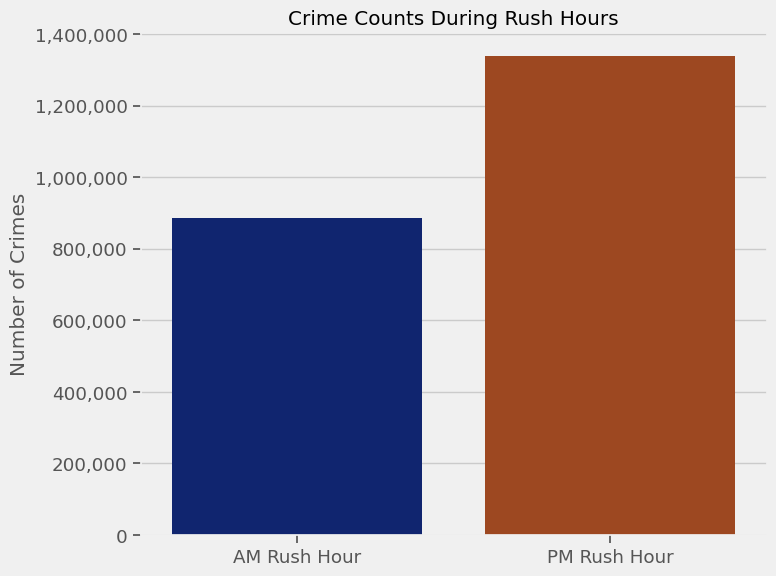

In [24]:
rush_hour_counts = [am_crimes, pm_crimes]
rush_hour_labels = ['AM Rush Hour', 'PM Rush Hour']

# Visualization
plt.figure(figsize=(8, 6))
sns.barplot(x=rush_hour_labels, y=rush_hour_counts, palette='dark')
plt.title('Crime Counts During Rush Hours')
plt.ylabel('Number of Crimes')

# Format y-axis labels to display large numbers with commas
formatter = mtick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

In [25]:
# Top 5 crimes during AM rush hour
top_5_am = am_rush['Primary Type'].value_counts().head(5)
top_5_am

Primary Type
THEFT              220879
BATTERY            118612
CRIMINAL DAMAGE     93153
BURGLARY            84944
OTHER OFFENSE       73991
Name: count, dtype: int64

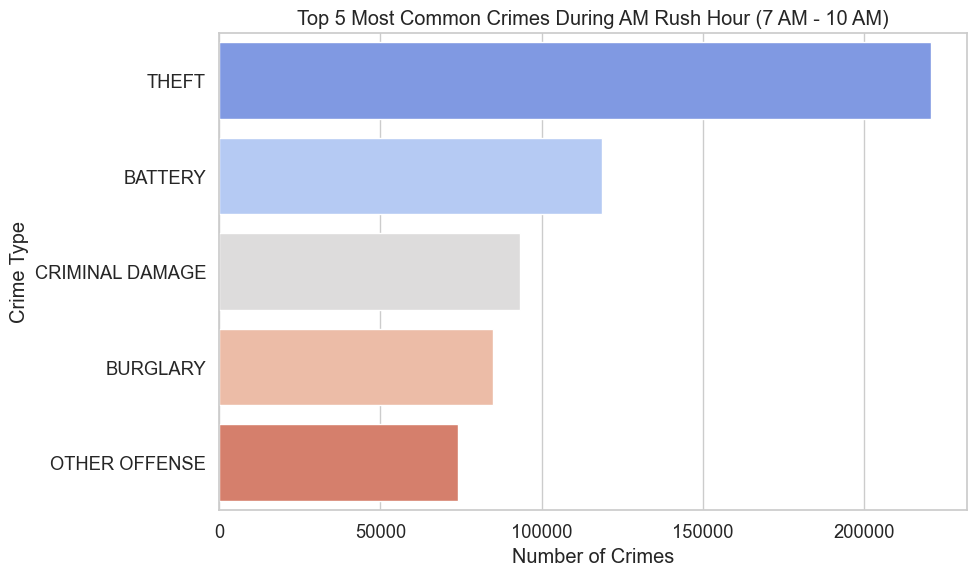

In [26]:
# Setting up the plotting environment
sns.set_style("whitegrid")

# Visualization of Top 5 crimes during AM rush hour
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_am.values, y=top_5_am.index, palette='coolwarm')
plt.title('Top 5 Most Common Crimes During AM Rush Hour (7 AM - 10 AM)')
plt.xlabel('Number of Crimes')
plt.ylabel('Crime Type')
plt.tight_layout()
plt.show()

In [27]:
# Top 5 crimes during PM rush hour
top_5_pm = pm_rush['Primary Type'].value_counts().head(5)
top_5_pm

Primary Type
THEFT              333344
BATTERY            228265
CRIMINAL DAMAGE    155030
NARCOTICS          107795
ASSAULT             95933
Name: count, dtype: int64

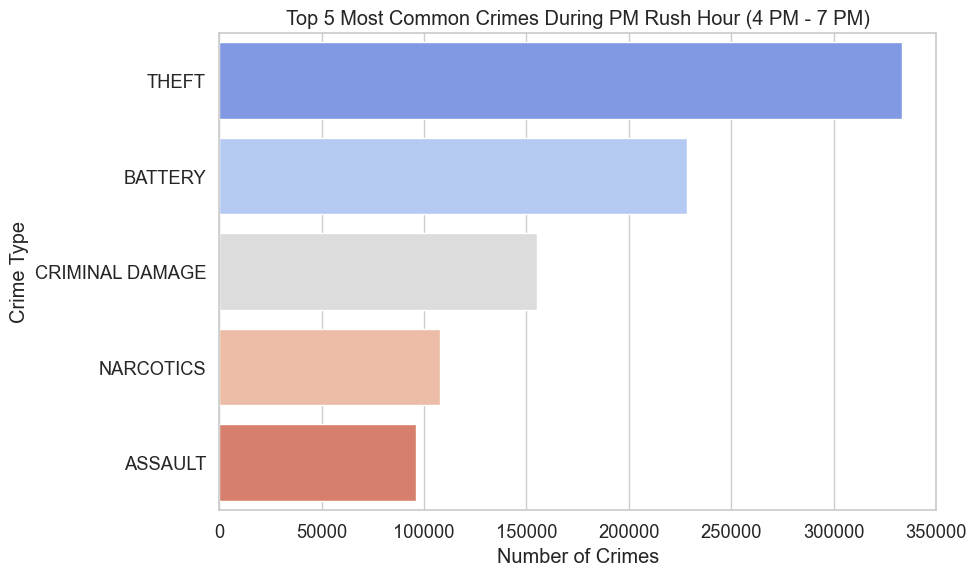

In [28]:
# Visualization of Top 5 crimes during PM rush hour
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_pm.values, y=top_5_pm.index, palette='coolwarm')
plt.title('Top 5 Most Common Crimes During PM Rush Hour (4 PM - 7 PM)')
plt.xlabel('Number of Crimes')
plt.ylabel('Crime Type')
plt.tight_layout()
plt.show()

In [29]:
# Motor Vehicle Thefts during AM rush hours
mv_am = am_rush[am_rush['Primary Type'] == 'MOTOR VEHICLE THEFT'].shape[0]
mv_am

48764

In [30]:
# Motor Vehicle Thefts during PM rush hours
mv_pm = pm_rush[pm_rush['Primary Type'] == 'MOTOR VEHICLE THEFT'].shape[0]
mv_pm

66116

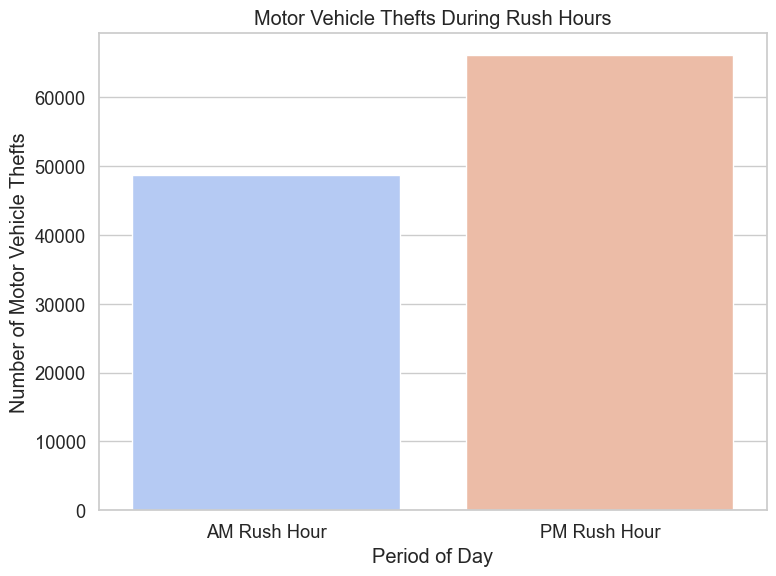

In [31]:
# Data preparation
motor_vehicle_thefts_counts = [mv_am, mv_pm]
rush_hour_periods = ['AM Rush Hour', 'PM Rush Hour']

# Visualization
plt.figure(figsize=(8, 6))
sns.barplot(x=rush_hour_periods, y=motor_vehicle_thefts_counts, palette='coolwarm')
plt.title('Motor Vehicle Thefts During Rush Hours')
plt.xlabel('Period of Day')
plt.ylabel('Number of Motor Vehicle Thefts')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Topic 5) Comparing Holidays:
* Answer the question: What are the top 3 holidays with the largest number of crimes?
* Answer the question:  For each of the top 3 holidays with the most crime, what are the top 5 most common crimes on that holiday?

In [32]:
## making a date range that covers full dataset
all_days = pd.date_range(chicago_df["Date"].min(), chicago_df["Date"].max())
all_days

DatetimeIndex(['2001-01-01', '2001-01-02', '2001-01-03', '2001-01-04',
               '2001-01-05', '2001-01-06', '2001-01-07', '2001-01-08',
               '2001-01-09', '2001-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', length=8035, freq='D')

In [33]:
# To get the holidays for Chicago, Illinois (IL)
iL_holidays = country_holidays('US', subdiv='IL')
iL_holidays

holidays.country_holidays('US', subdiv='IL')

In [34]:
## Saving holiday types as column
chicago_df['IL Holiday'] = [iL_holidays.get(day) for day in chicago_df['Date']]
chicago_df.head()

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,Date,Year,Month,MonthName,DayOfWeek,DayNum,HourOfDay,IL Holiday
Date,,,,,,,,,,,,,,,,,,,
2001-01-01 01:00:00,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185,2001-01-01,2001,1,January,Monday,0,1,New Year's Day
2001-01-01 13:00:00,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841,2001-01-01,2001,1,January,Monday,0,13,New Year's Day
2001-01-01 13:00:00,1324743,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970,2001-01-01,2001,1,January,Monday,0,13,New Year's Day
2001-01-01 01:00:00,1310717,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032,2001-01-01,2001,1,January,Monday,0,1,New Year's Day
2001-01-01 01:00:00,1318099,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020,2001-01-01,2001,1,January,Monday,0,1,New Year's Day


In [35]:
# Filter for crimes on holidays
holiday_crimes = chicago_df.dropna(subset=['IL Holiday'])

# Count crimes for each holiday
crimes_by_holiday = holiday_crimes['IL Holiday'].value_counts()
crimes_by_holiday

IL Holiday
New Year's Day                                     32725
Independence Day                                   22672
Labor Day                                          22164
Memorial Day                                       21125
Columbus Day                                       20920
Veterans Day                                       20418
Casimir Pulaski Day                                19128
Lincoln's Birthday                                 18165
Martin Luther King Jr. Day                         17916
Washington's Birthday                              17597
Thanksgiving                                       14798
Christmas Day                                      12418
Election Day                                        6342
Independence Day (observed)                         5884
Veterans Day (observed)                             5842
Lincoln's Birthday (observed)                       5156
Christmas Day (observed)                            4929
New Year's Day (obse

In [36]:
top_3_holidays = crimes_by_holiday.head(3)
print("Top 3 Holidays with Most Crimes:")
print(top_3_holidays)

Top 3 Holidays with Most Crimes:
IL Holiday
New Year's Day      32725
Independence Day    22672
Labor Day           22164
Name: count, dtype: int64


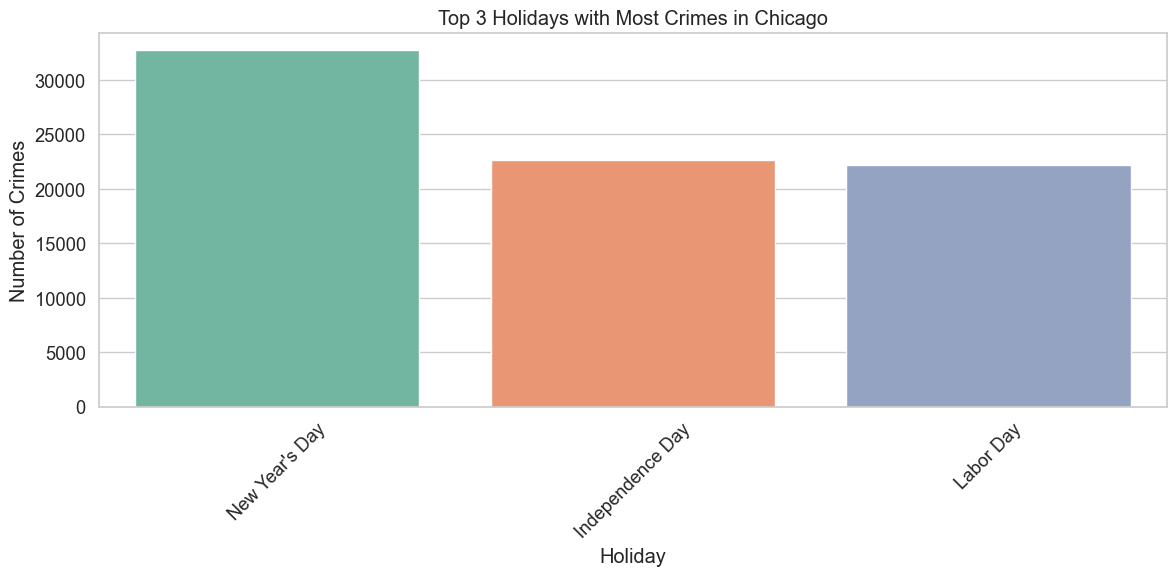

In [37]:
# Plot the Top 3 Holidays with Most Crimes
top_3_holidays_df = top_3_holidays.reset_index()
top_3_holidays_df.columns = ['Holiday', 'Number of Crimes']

# Visualization
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Holiday', y='Number of Crimes', data=top_3_holidays_df, palette='Set2')
ax.set_title('Top 3 Holidays with Most Crimes in Chicago')
ax.set_xlabel('Holiday')
ax.set_ylabel('Number of Crimes')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

In [38]:
# Determine Top 5 Most Common Crimes on the Top 3 Holidays
for holiday in top_3_holidays.index:
    print(f"\nMost common crimes on {holiday}:")
    common_crimes = holiday_crimes[holiday_crimes['IL Holiday'] == holiday]['Primary Type'].value_counts().head(5)
    print(common_crimes)


Most common crimes on New Year's Day:
Primary Type
THEFT                         6845
BATTERY                       6043
CRIMINAL DAMAGE               3236
DECEPTIVE PRACTICE            2934
OFFENSE INVOLVING CHILDREN    2380
Name: count, dtype: int64

Most common crimes on Independence Day:
Primary Type
BATTERY            5805
THEFT              4074
CRIMINAL DAMAGE    3309
ASSAULT            1547
NARCOTICS          1522
Name: count, dtype: int64

Most common crimes on Labor Day:
Primary Type
BATTERY            4607
THEFT              4520
CRIMINAL DAMAGE    2475
NARCOTICS          2078
ASSAULT            1525
Name: count, dtype: int64


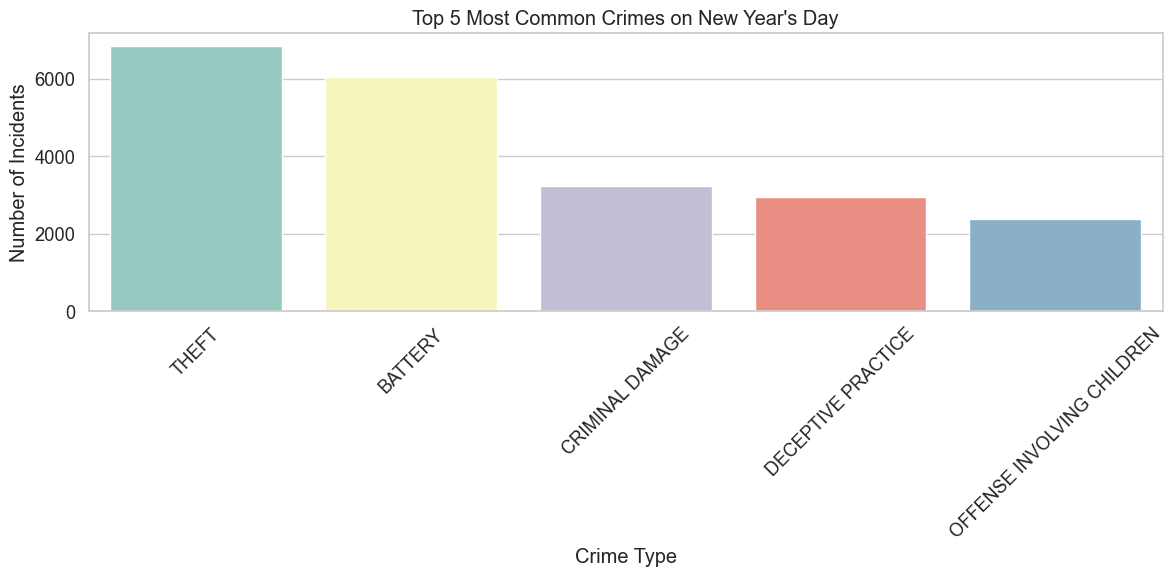

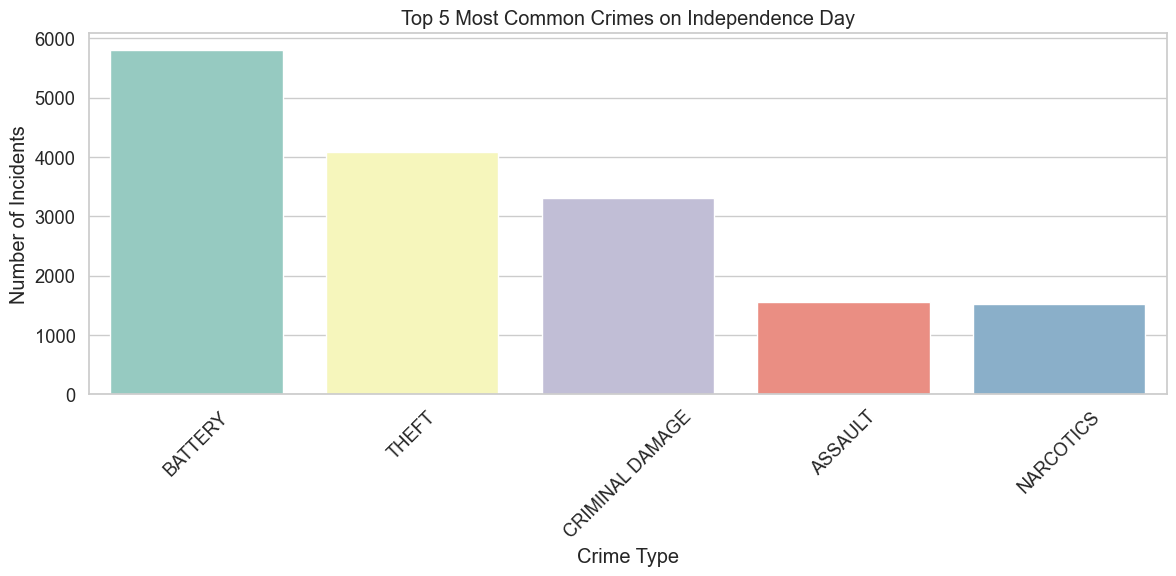

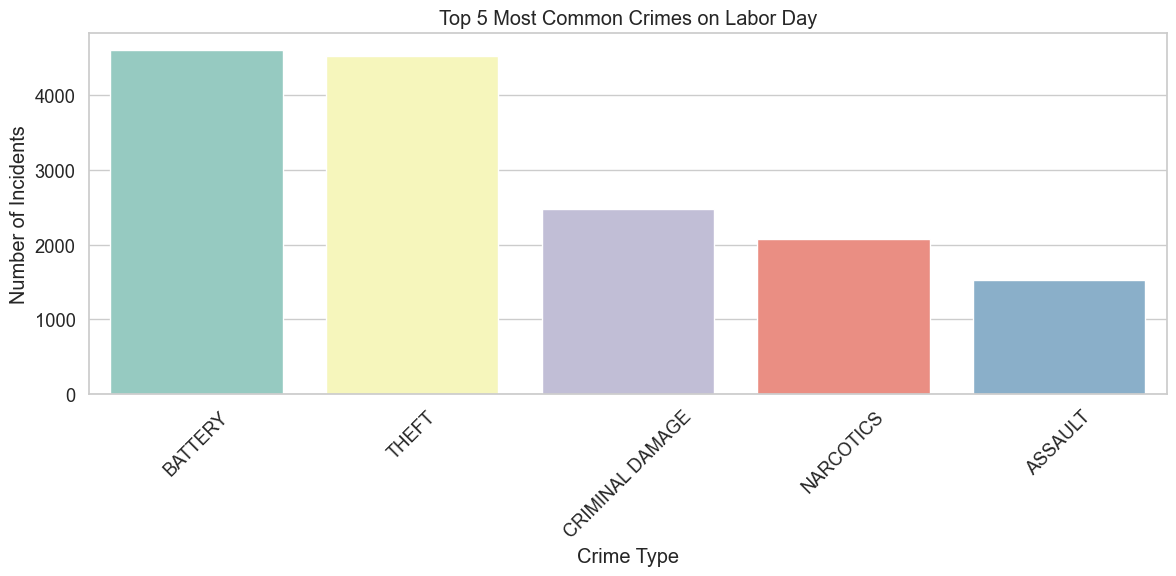

In [39]:
# Plot the Top 5 Most Common Crimes for Each Top Holiday
for holiday in top_3_holidays.index:
    common_crimes = holiday_crimes[holiday_crimes['IL Holiday'] == holiday]['Primary Type'].value_counts().head(5)
    common_crimes_df = common_crimes.reset_index()
    common_crimes_df.columns = ['Crime Type', 'Number of Incidents']
    
    # Visualization
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Crime Type', y='Number of Incidents', data=common_crimes_df, palette='Set3')
    ax.set_title(f'Top 5 Most Common Crimes on {holiday}')
    ax.set_xlabel('Crime Type')
    ax.set_ylabel('Number of Incidents')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.tight_layout()
    plt.show()

## Part 2

### Additional Imports

In [40]:
import statsmodels.tsa.api as tsa
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split
import pmdarima as pm

### Custom Functions

In [41]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [42]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

In [43]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [45]:
chicago_df

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,Date,Year,Month,MonthName,DayOfWeek,DayNum,HourOfDay,IL Holiday
Date,,,,,,,,,,,,,,,,,,,
2001-01-01 01:00:00,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185,2001-01-01,2001,1,January,Monday,0,1,New Year's Day
2001-01-01 13:00:00,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841,2001-01-01,2001,1,January,Monday,0,13,New Year's Day
2001-01-01 13:00:00,1324743,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970,2001-01-01,2001,1,January,Monday,0,13,New Year's Day
2001-01-01 01:00:00,1310717,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032,2001-01-01,2001,1,January,Monday,0,1,New Year's Day
2001-01-01 01:00:00,1318099,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020,2001-01-01,2001,1,January,Monday,0,1,New Year's Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 12:50:00,12938029,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966,2022-12-31,2022,12,December,Saturday,5,12,None
2022-12-31 12:50:00,12937822,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669,2022-12-31,2022,12,December,Saturday,5,12,None
2022-12-31 00:52:00,12937583,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098,2022-12-31,2022,12,December,Saturday,5,0,None


In [46]:
chicago_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7713109 entries, 2001-01-01 01:00:00 to 2022-12-31 12:59:00
Data columns (total 19 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Primary Type          object 
 2   Description           object 
 3   Location Description  object 
 4   Arrest                bool   
 5   Domestic              bool   
 6   Beat                  int64  
 7   District              float64
 8   Ward                  float64
 9   Latitude              float64
 10  Longitude             float64
 11  Date                  object 
 12  Year                  int32  
 13  Month                 int32  
 14  MonthName             object 
 15  DayOfWeek             object 
 16  DayNum                int32  
 17  HourOfDay             int32  
 18  IL Holiday            object 
dtypes: bool(2), float64(4), int32(4), int64(2), object(7)
memory usage: 956.3+ MB


In [47]:
chicago_df.index

DatetimeIndex(['2001-01-01 01:00:00', '2001-01-01 13:00:00',
               '2001-01-01 13:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               '2001-01-01 01:00:00', '2001-01-01 01:00:00',
               ...
               '2022-12-31 12:41:00', '2022-12-31 00:42:00',
               '2022-12-31 00:44:00', '2022-12-31 00:45:00',
               '2022-12-31 12:45:00', '2022-12-31 12:50:00',
               '2022-12-31 12:50:00', '2022-12-31 00:52:00',
               '2022-12-31 12:52:00', '2022-12-31 12:59:00'],
              dtype='datetime64[ns]', name='Date', length=7713109, freq=None)

## Theft and Assault Crimes Data Analysis

### Transform the data to obtain a time series of the crime count per month using .size()

In [48]:
theft_counts = chicago_df[chicago_df['Primary Type'] == 'THEFT'].resample('M').size()
theft_counts

Date
2001-01-31    7867
2001-02-28    6669
2001-03-31    7766
2001-04-30    7702
2001-05-31    8420
              ... 
2022-08-31    5244
2022-09-30    5117
2022-10-31    5242
2022-11-30    4717
2022-12-31    4413
Freq: M, Length: 264, dtype: int64

In [49]:
assault_counts = chicago_df[chicago_df['Primary Type'] == 'ASSAULT'].resample('M').size()
assault_counts

Date
2001-01-31    2123
2001-02-28    2029
2001-03-31    2824
2001-04-30    2746
2001-05-31    2903
              ... 
2022-08-31    1984
2022-09-30    1891
2022-10-31    1839
2022-11-30    1659
2022-12-31    1569
Freq: M, Length: 264, dtype: int64

In [50]:
theft_counts.index

DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
               '2001-05-31', '2001-06-30', '2001-07-31', '2001-08-31',
               '2001-09-30', '2001-10-31',
               ...
               '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30',
               '2022-07-31', '2022-08-31', '2022-09-30', '2022-10-31',
               '2022-11-30', '2022-12-31'],
              dtype='datetime64[ns]', name='Date', length=264, freq='M')

In [51]:
assault_counts.index

DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
               '2001-05-31', '2001-06-30', '2001-07-31', '2001-08-31',
               '2001-09-30', '2001-10-31',
               ...
               '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30',
               '2022-07-31', '2022-08-31', '2022-09-30', '2022-10-31',
               '2022-11-30', '2022-12-31'],
              dtype='datetime64[ns]', name='Date', length=264, freq='M')

### Plot a line graph with each of the crimes as a separate line

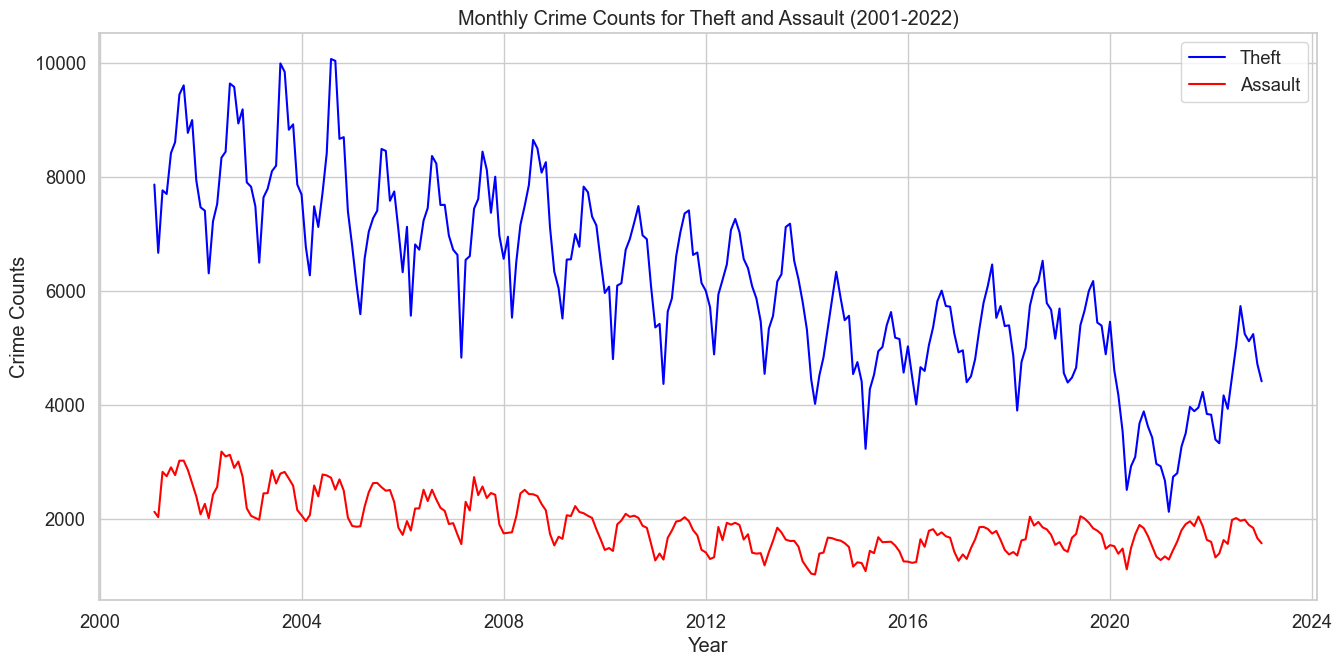

In [52]:
# Plotting the line graph
plt.figure(figsize=(14, 7))
plt.plot(theft_counts.index, theft_counts, label='Theft', color='blue')
plt.plot(assault_counts.index, assault_counts, label='Assault', color='red')
plt.title('Monthly Crime Counts for Theft and Assault (2001-2022)')
plt.xlabel('Year')
plt.ylabel('Crime Counts')
plt.legend()
plt.show()

### Check for and address null values

In [53]:
theft_counts.isna().sum()

0

In [54]:
assault_counts.isna().sum()

0

### Decompose the Time series to detect seasonality and decide whether to use a seasonal model or not

C:\Users\bandi\AppData\Local\Temp\ipykernel_40408\3302818135.py:6: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


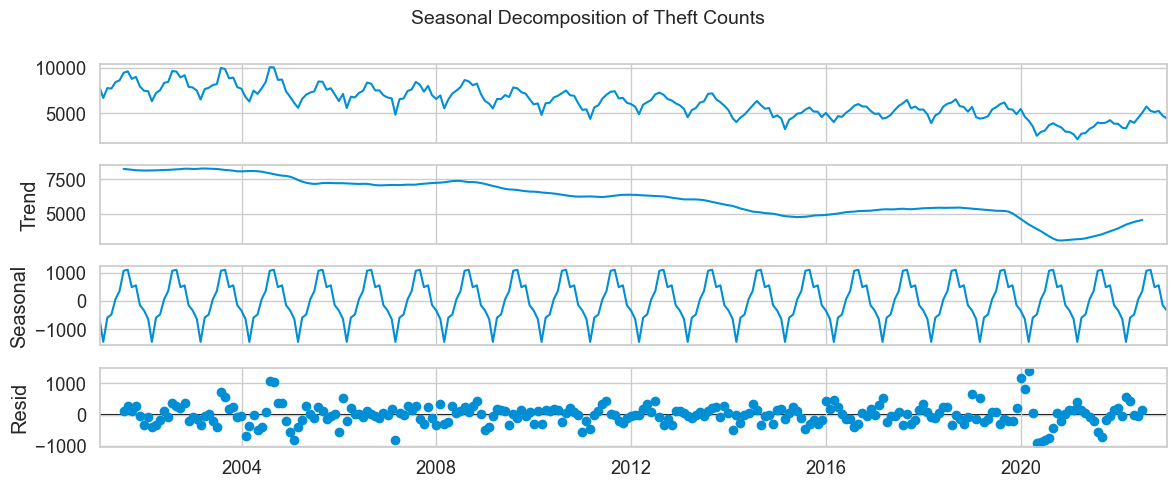

In [55]:
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(theft_counts)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.suptitle('Seasonal Decomposition of Theft Counts', fontsize=14)
fig.tight_layout()

C:\Users\bandi\AppData\Local\Temp\ipykernel_40408\1439391124.py:6: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


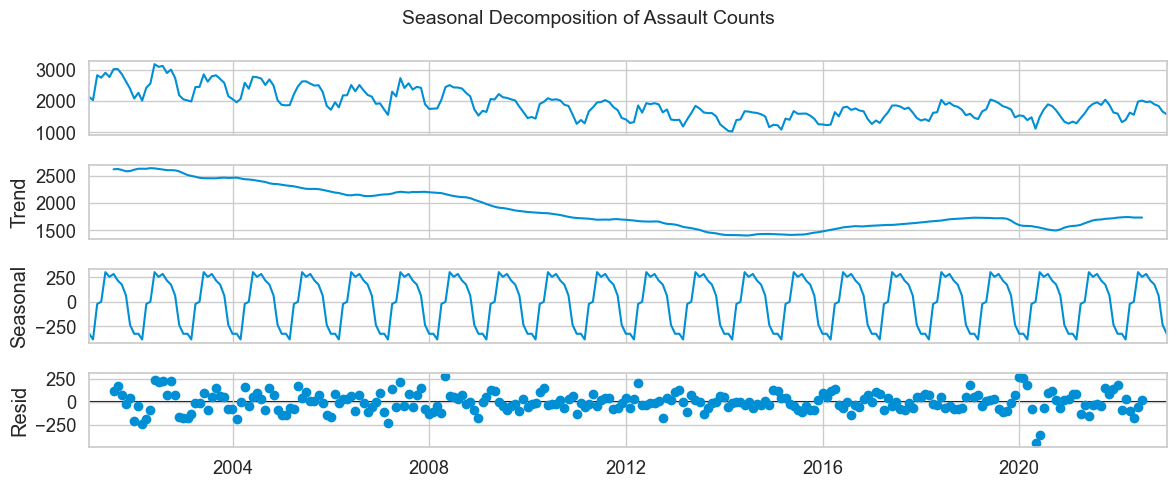

In [56]:
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(assault_counts)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.suptitle('Seasonal Decomposition of Assault Counts', fontsize=14)
fig.tight_layout()

### Determine if nonseasonal and/or seasonal differencing is required

In [57]:
# Check for stationarity
get_adfuller_results(theft_counts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.393935,13,250,0.58518,0.05,False


In [58]:
# Check for stationarity
get_adfuller_results(assault_counts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.836624,15,248,0.362437,0.05,False


In [59]:
# determine d
d = ndiffs(theft_counts)
print (f'd = {d}')
# determine D
D = nsdiffs(theft_counts, m = 12)
print (f'D = {D}')

d = 1
D = 0


In [60]:
# determine d
d = ndiffs(assault_counts)
print (f'd = {d}')
# determine D
D = nsdiffs(assault_counts, m = 12)
print (f'D = {D}')

d = 1
D = 0


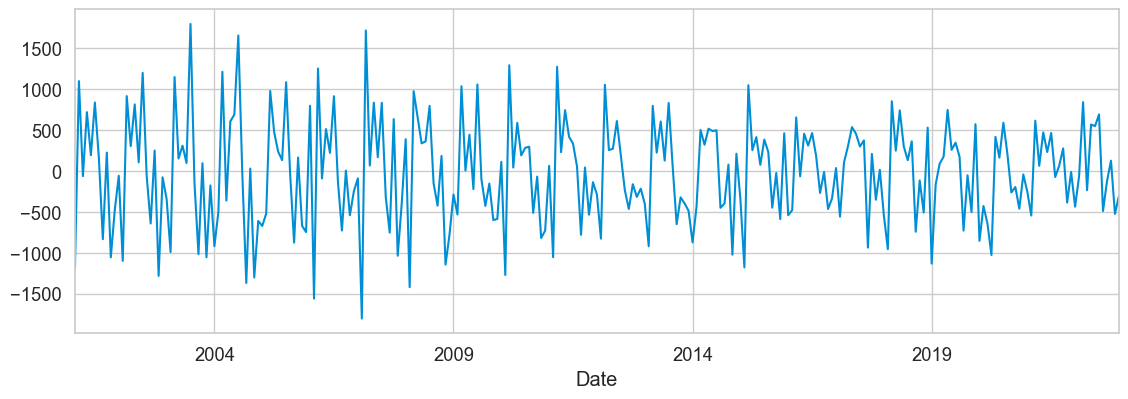

In [61]:
# Difference once
theft_ts_diff = theft_counts.diff().dropna()

# Visualize the differenced data
theft_ts_diff.plot();

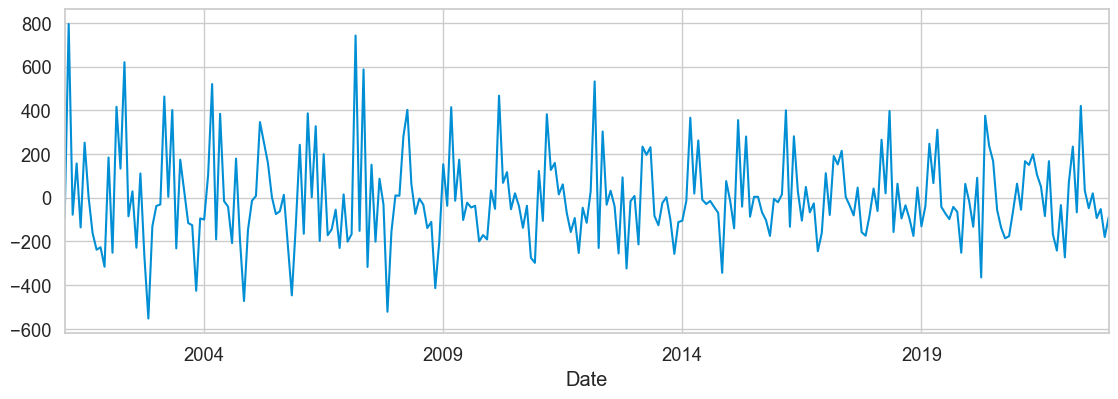

In [62]:
# Difference once
assault_ts_diff = assault_counts.diff().dropna()

# Visualize the differenced data
assault_ts_diff.plot();

In [63]:
# Check the differenced data for stationarity with the Ad Fuller Test
theft_adfuller_results = get_adfuller_results(theft_ts_diff, label='differenced')
theft_adfuller_results

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
differenced,-3.953728,12,250,0.001673,0.05,True


In [64]:
# Check the differenced data for stationarity with the Ad Fuller Test
assault_adfuller_results = get_adfuller_results(assault_ts_diff, label='differenced')
assault_adfuller_results

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
differenced,-3.936162,14,248,0.001784,0.05,True


Both differenced datasets are now stationary.

### Use the ACF and PACF plots of stationarity data to estimate initial orders

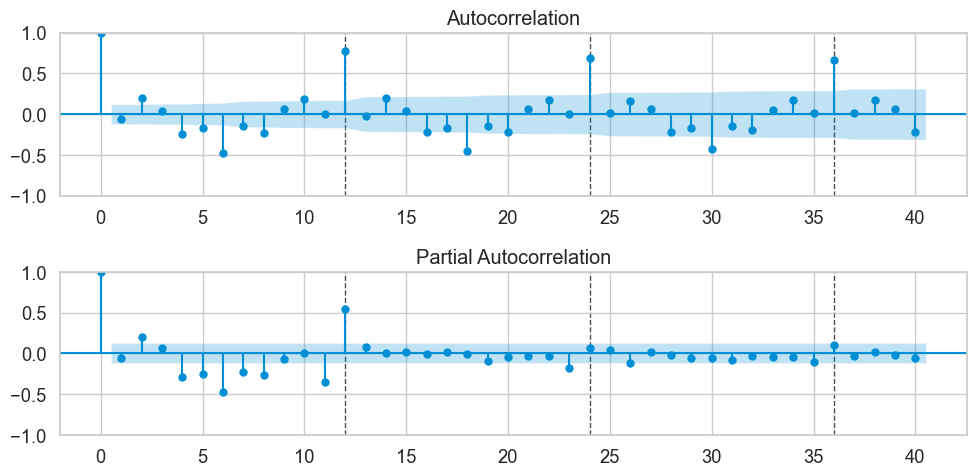

In [65]:
# Check the ACF/PACF Plots of the differenced data to determine the orders for the Theft counts
plot_acf_pacf(theft_ts_diff, annotate_seas=True, m = 12);

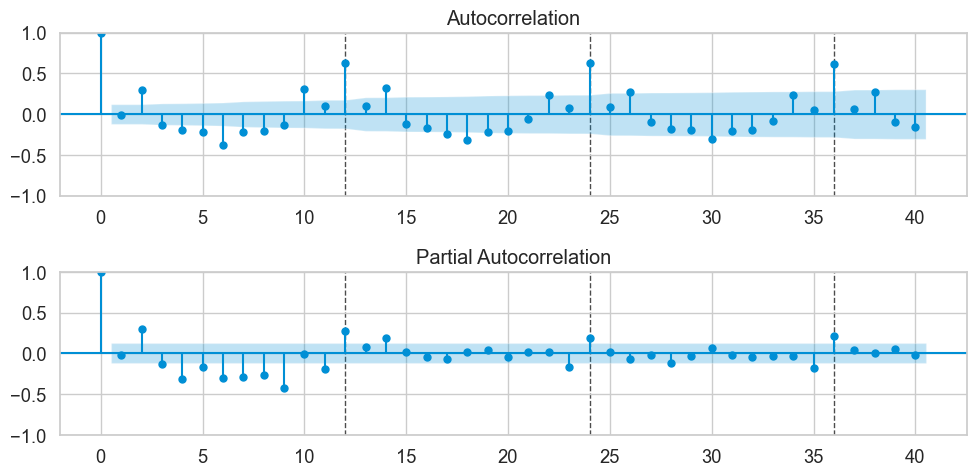

In [66]:
# Check the ACF/PACF Plots of the differenced data to determine the orders for the Assault counts
plot_acf_pacf(assault_ts_diff, annotate_seas=True, m = 12);

## Theft Crime Data Analysis

### Train Test Split
* Split the time series into training and test data (Remember we want to predict 6 months)

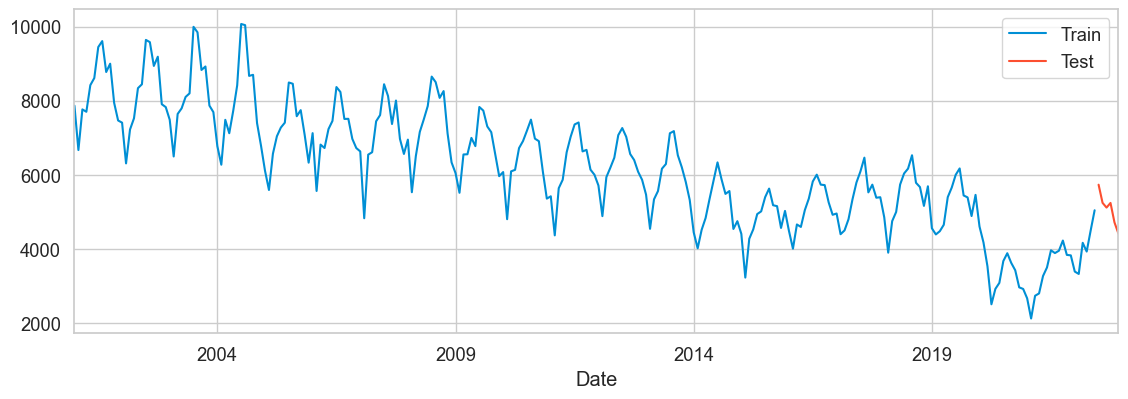

In [67]:
# Set test_size to 6 for 6 months
n_test_lags = 6

# Modeling to predict 6 months into the future
theft_train, theft_test = train_test_split(theft_counts, test_size=n_test_lags)

# Visualize train-test-split
ax = theft_train.plot(label='Train')
theft_test.plot(ax=ax, label='Test')
ax.legend();

### Fit Initial Model
* Fit a manual ARIMA/SARIMA model based on the orders determined during your exploration.
    * Make forecasts with your model.
    * Plot the forecasts versus the test data
    * Obtain metrics for evaluation

In [68]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

theft_sarima = tsa.ARIMA(theft_train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
theft_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  258
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1874.541
Date:                          Sun, 07 Apr 2024   AIC                           3759.083
Time:                                  20:06:54   BIC                           3776.828
Sample:                              01-31-2001   HQIC                          3766.219
                                   - 06-30-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9990      0.378      2.642      0.008       0.258       1.740
ma.L1         -0.9990      0.476     -2.100      0.036      -1.931      -0.067
ar.S.L12       0.9718      0.008    118.827      0.000       0.956       0.988
ma.S.L12      -0.6605      0.042    -15.573      0.000      -0.744      -0.577
sigma2      1.057e+05   1.11e+04      9.557      0.000     8.4e+04    1.27e+05
===================================================================================
Ljung-Box (L1) (Q):                  11.18   Jarque-Bera (JB):                12.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -0.25
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

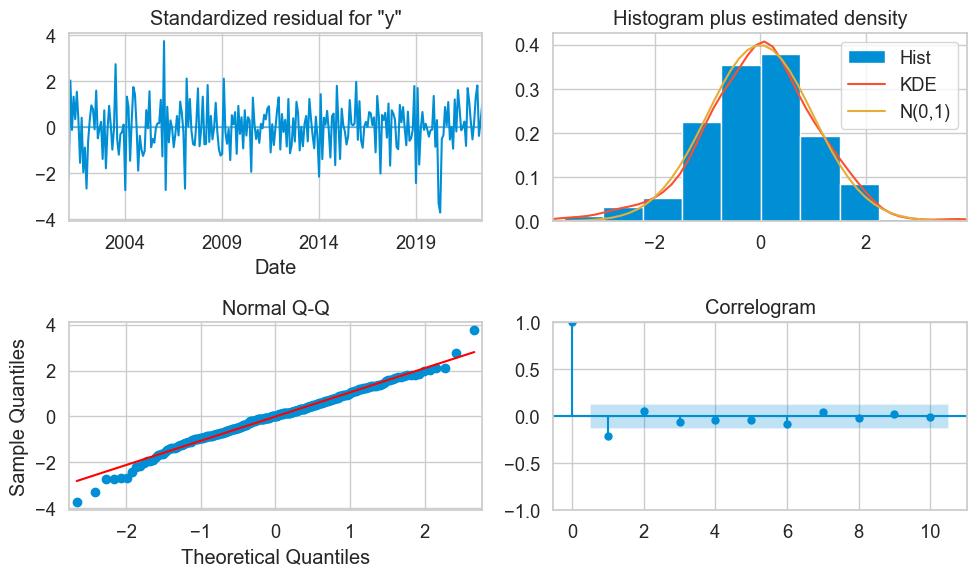

In [69]:
# Obtain diagnostic plots
fig = theft_sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 239.153
- MSE = 84,897.888
- RMSE = 291.372
- R^2 = 0.519
- MAPE = 4.87%


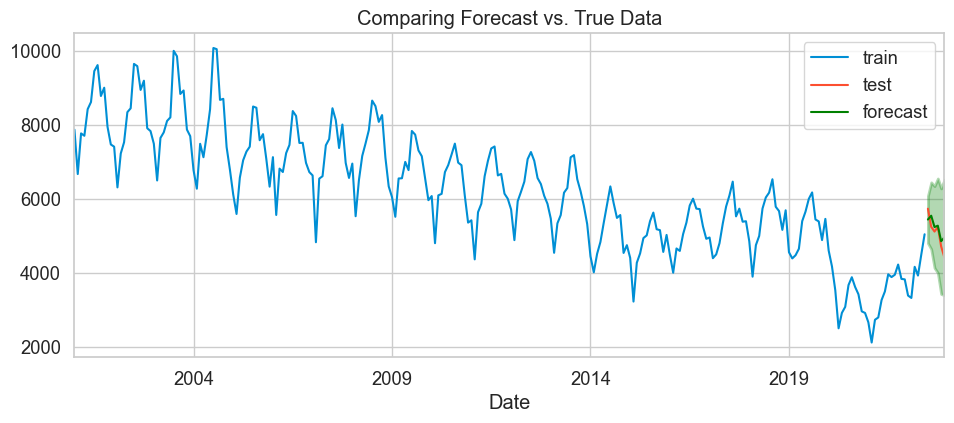

In [70]:
# Obtain forecast as a dataframe with confidence intervals
theft_forecast_df = theft_sarima.get_forecast(steps=len(theft_test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(theft_train, theft_test, theft_forecast_df);
# Obtain metrics
regression_metrics_ts(theft_test, theft_forecast_df['mean'])

### Tune with Auto_Arima
* Tune with pmdarima's auto_arima
    * Fit a model on training data with the best parameters from auto_arima
    * Obtain metrics for evaluation
    * Make forecasts with the auto_arima model
    * Plot the forecasts versus the test data

In [71]:
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    theft_train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4050.524, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3791.710, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3914.631, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4048.603, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4050.805, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3774.214, Time=0.45 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3743.879, Time=1.18 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3743.960, Time=0.46 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.55 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3742.900, Time=1.04 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3870.719, Time=0.44 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3913.736, Time=0.14 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3754.859, Time=0.85 sec
 ARIMA(2,1,0)(1,0,2)[12] inte

In [72]:
# the auto_arima will store our best nonseasonal and seasonal orders separtely
print(auto_model.order)
print(auto_model.seasonal_order)

(1, 1, 0)
(1, 0, 2, 12)


In [73]:
# Try auto_arima orders
theft_auto_sarima = tsa.ARIMA(theft_train, order = auto_model.order, seasonal_order=auto_model.seasonal_order).fit()

# Obtain summary of the best model from auto_arima
theft_auto_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                     y   No. Observations:                  258
Model:             ARIMA(1, 1, 0)x(1, 0, [1, 2], 12)   Log Likelihood               -1865.634
Date:                               Sun, 07 Apr 2024   AIC                           3741.268
Time:                                       20:07:16   BIC                           3759.013
Sample:                                   01-31-2001   HQIC                          3748.404
                                        - 06-30-2022                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2251      0.046     -4.934      0.000      -0.315      -0.136
ar.S.L12       0.9778      0.008    120.053      0.000       0.962       0.994
ma.S.L12      -0.5771      0.059     -9.815      0.000      -0.692      -0.462
ma.S.L24      -0.1202      0.068     -1.758      0.079      -0.254       0.014
sigma2      1.038e+05   7353.367     14.120      0.000    8.94e+04    1.18e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                30.54
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.44
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

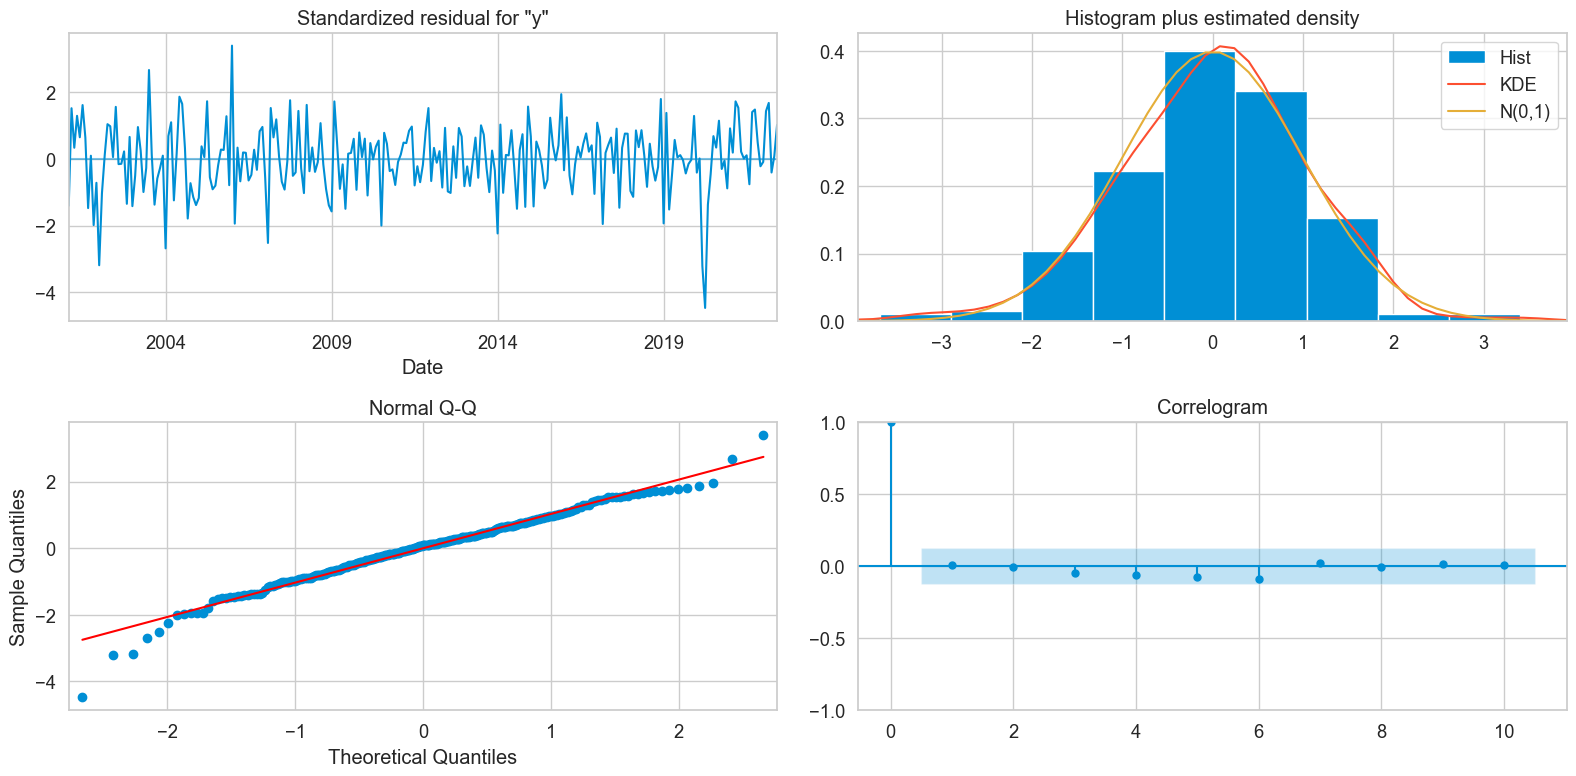

In [74]:
# Obtain diagnostic plots
fig = theft_auto_sarima.plot_diagnostics()
fig.set_size_inches(16,8)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 211.160
- MSE = 72,805.981
- RMSE = 269.826
- R^2 = 0.587
- MAPE = 4.27%


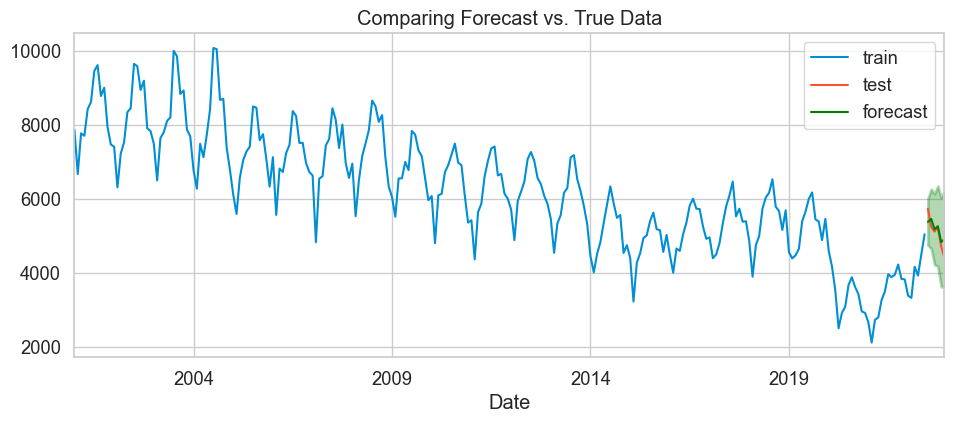

In [75]:
# Obtain forecast as a dataframe with confidence intervals
theft_forecast_df = theft_auto_sarima.get_forecast(steps=len(theft_test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(theft_train, theft_test, theft_forecast_df);
# Obtain metrics
regression_metrics_ts(theft_test, theft_forecast_df['mean'])

### Select the final model and justify your choice. (Which metrics or diagnostics support your choice?)

In [76]:
# Define the data for the comparison as dictionaries
theft_initial_model_metrics = {
    'MAE': 239,
    'MSE': 84897,
    'RMSE': 291,
    'R²': 0.519,
    'MAPE': '4.87%',
    'AIC': 3759,
    'BIC': 3776
}

theft_auto_model_metrics = {
    'MAE': 211,
    'MSE': 72805,
    'RMSE': 269,
    'R²': 0.587,
    'MAPE': '4.27%',
    'AIC': 3741,
    'BIC': 3759
}

column_names = {
    'Initial Model': 'Initial Model (1,1,1)(1, 0, 1, 12)',
    'Auto Model': 'Auto Model (1,1,0)(1, 0, 2, 12)'
}

# Create a DataFrame from the dictionaries
theft_comparison_df = pd.DataFrame({
    column_names['Initial Model']: theft_initial_model_metrics,
    column_names['Auto Model']: theft_auto_model_metrics
})

# Display the DataFrame
theft_comparison_df.T

,MAE,MSE,RMSE,R²,MAPE,AIC,BIC
"Initial Model (1,1,1)(1, 0, 1, 12)",239,84897,291,0.519,4.87%,3759,3776
"Auto Model (1,1,0)(1, 0, 2, 12)",211,72805,269,0.587,4.27%,3741,3759


The better choice is the (1,1,0)(1, 0, 2, 12) model of the auto model for the Theft of Chicago crime data analysis.

It performs better in all the key indicators:
* It has lower errors (MAE, MSE, RMSE, MAPE) and better fits with higher R².
* It has lower AIC and BIC scores than the initial model.

### Make true future forecasts using the entire dataset (for dates beyond the entire ts)

In [77]:
# These are the parameters of our final model
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 2  # Seasonal MA
m = 12 # Seasonal period

theft_final_model = tsa.ARIMA(theft_counts, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

In [78]:
len(theft_test)

6

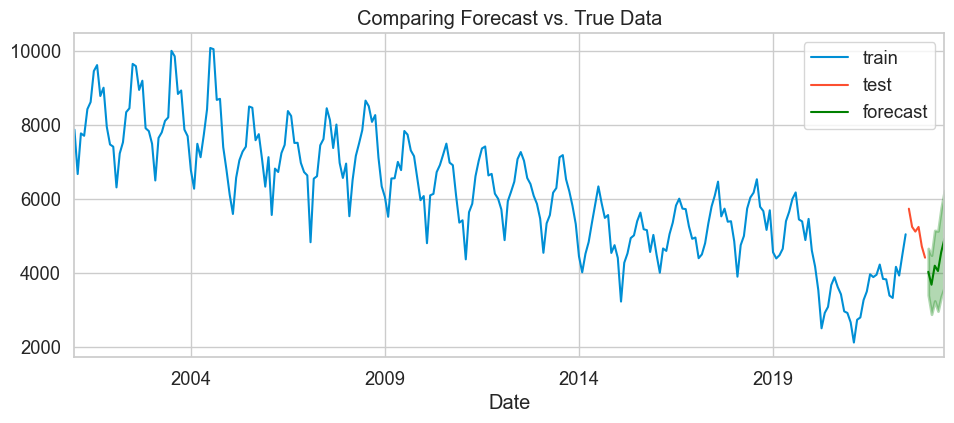

In [79]:
# Obtain future forecasts beyond test data
theft_forecast_df  = theft_final_model.get_forecast(len(theft_test)).summary_frame()
plot_forecast(theft_train,theft_test,theft_forecast_df);

### Answer the following questions:

* Calculate the predicted net change in the number (raw counts) of this type of crime from the beginning of the forecast to the end.
* Convert the raw delta into a percent change.

In [80]:
# view the starting and ending dates of our forecast
theft_forecast_df.index[0],theft_forecast_df.index[-1]

(Timestamp('2023-01-31 00:00:00'), Timestamp('2023-06-30 00:00:00'))

In [81]:
# Defining the starting value
theft_starting_count = theft_forecast_df['mean'].iloc[0]
theft_starting_count

4031.3755643071436

In [82]:
# Defining the final value
theft_final_count = theft_forecast_df['mean'].iloc[-1]
theft_final_count

4920.794599522909

In [83]:
# Calculate the net change in the number of crimes
theft_net_change = theft_final_count - theft_starting_count
theft_net_change

889.4190352157657

In [84]:
# Calculate the percent change
theft_percent_change = (theft_net_change / theft_starting_count) * 100
theft_percent_change

22.062420655879194

In [85]:
print(f'Predicted net change in number of Theft crimes: {theft_net_change:,.2f}')

Predicted net change in number of Theft crimes: 889.42


In [86]:
print(f'Percent change in number of Theft crimes: {theft_percent_change:.2f}%')

Percent change in number of Theft crimes: 22.06%


## Assault Crime Data Analysis

### Train Test Split

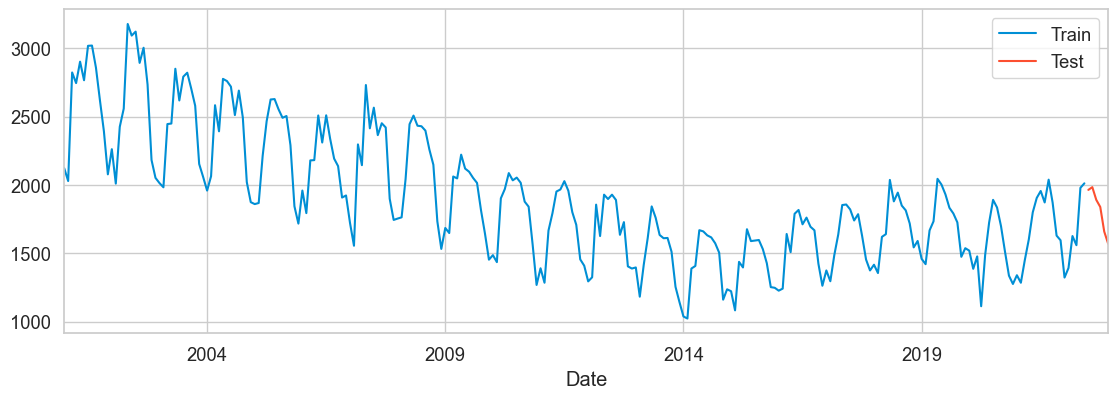

In [87]:
# Set test_size to 6 for 6 months
n_test_lags = 6

# Modeling to predict 6 months into the future
assault_train, assault_test = train_test_split(assault_counts, test_size=n_test_lags)

# Visualize train-test-split
ax = assault_train.plot(label='Train')
assault_test.plot(ax=ax, label='Test')
ax.legend();

### Fit Initial Model

In [88]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 0  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

assault_sarima = tsa.ARIMA(assault_train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
assault_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  258
Model:             ARIMA(1, 1, 0)x(0, 0, [1], 12)   Log Likelihood               -1698.062
Date:                            Sun, 07 Apr 2024   AIC                           3402.125
Time:                                    20:07:18   BIC                           3412.772
Sample:                                01-31-2001   HQIC                          3406.407
                                     - 06-30-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1412      0.072     -1.963      0.050      -0.282      -0.000
ma.S.L12       0.5014      0.055      9.142      0.000       0.394       0.609
sigma2      3.171e+04   2316.244     13.689      0.000    2.72e+04    3.62e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                33.46
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                             0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

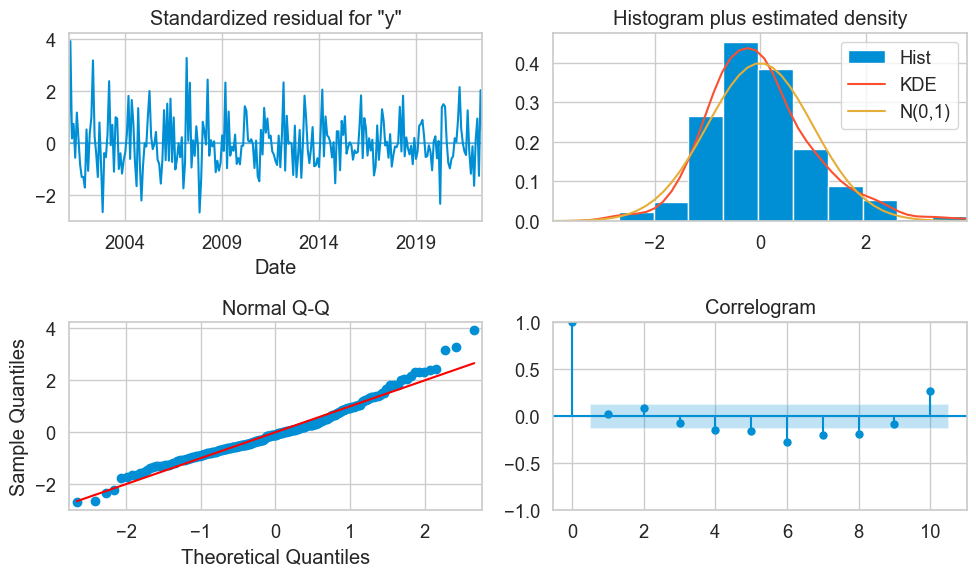

In [89]:
# Obtain diagnostic plots
fig = assault_sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 166.621
- MSE = 40,920.972
- RMSE = 202.289
- R^2 = -0.730
- MAPE = 9.77%


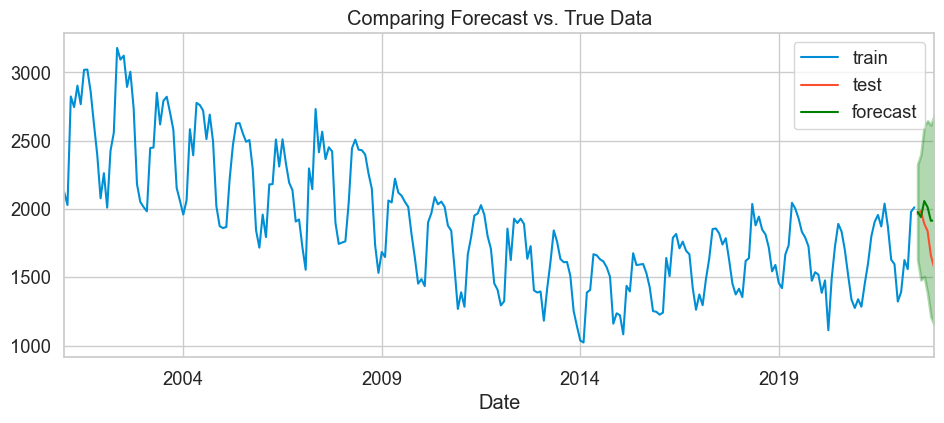

In [91]:
# Obtain forecast as a dataframe with confidence intervals
assault_forecast_df = assault_sarima.get_forecast(steps=len(assault_test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(assault_train, assault_test, assault_forecast_df);
# Obtain metrics
regression_metrics_ts(assault_test, assault_forecast_df['mean'])

### Tune with Auto_Arima

In [92]:
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    assault_train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3483.860, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3318.021, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3405.065, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3481.861, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3485.758, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3404.125, Time=0.15 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.41 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=3337.645, Time=0.10 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=3313.233, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=3462.085, Time=0.11 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=3

In [93]:
# the auto_arima will store our best nonseasonal and seasonal orders separtely
print(auto_model.order)
print(auto_model.seasonal_order)

(4, 1, 0)
(2, 0, 2, 12)


In [94]:
# Try auto_arima orders
assault_auto_sarima = tsa.ARIMA(assault_train, order = auto_model.order, seasonal_order=auto_model.seasonal_order).fit()

# Obtain summary of the best model from auto_arima
assault_auto_sarima.summary()

C:\Users\bandi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                     y   No. Observations:                  258
Model:             ARIMA(4, 1, 0)x(2, 0, [1, 2], 12)   Log Likelihood               -1592.590
Date:                               Sun, 07 Apr 2024   AIC                           3203.181
Time:                                       20:08:54   BIC                           3235.122
Sample:                                   01-31-2001   HQIC                          3216.026
                                        - 06-30-2022                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4153      0.061     -6.801      0.000      -0.535      -0.296
ar.L2         -0.2582      0.067     -3.871      0.000      -0.389      -0.127
ar.L3         -0.2429      0.064     -3.770      0.000      -0.369      -0.117
ar.L4         -0.1591      0.065     -2.455      0.014      -0.286      -0.032
ar.S.L12       1.9977      0.010    205.721      0.000       1.979       2.017
ar.S.L24      -0.9988      0.009   -105.976      0.000      -1.017      -0.980
ma.S.L12      -1.9698      0.082    -23.914      0.000      -2.131      -1.808
ma.S.L24       0.9747      0.087     11.168      0.000       0.804       1.146
sigma2      1.071e+04   1.59e-05   6.73e+08      0.000    1.07e+04    1.07e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                27.82
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.10
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.42e+23. Standard errors may be unstable.
"""

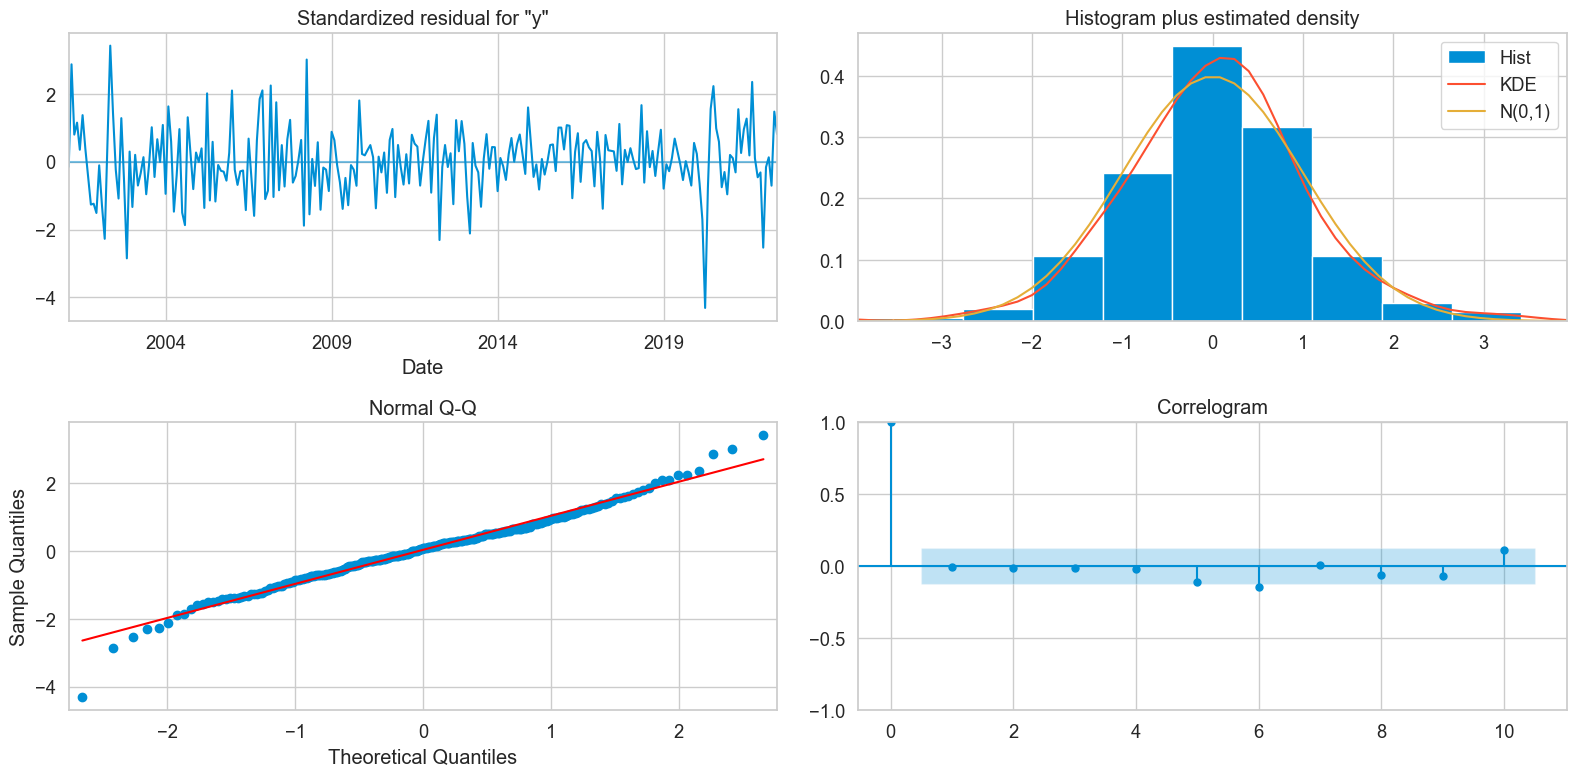

In [95]:
# Obtain diagnostic plots
fig = assault_auto_sarima.plot_diagnostics()
fig.set_size_inches(16,8)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 47.017
- MSE = 2,745.511
- RMSE = 52.398
- R^2 = 0.884
- MAPE = 2.60%


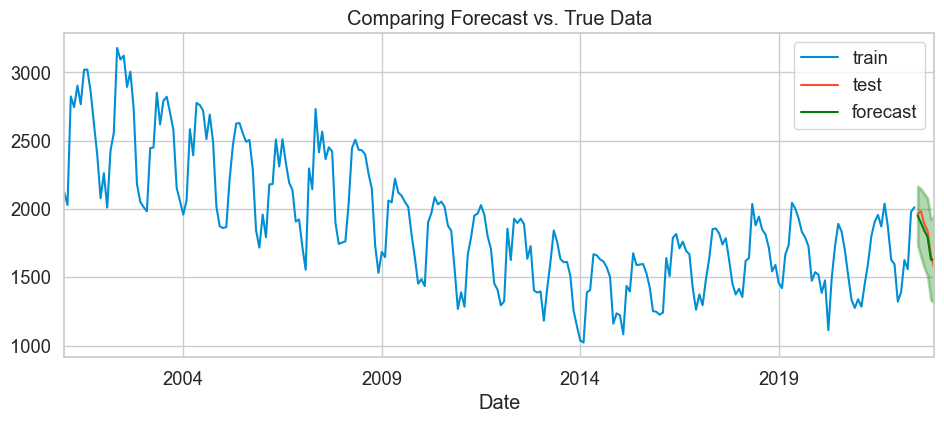

In [96]:
# Obtain forecast as a dataframe with confidence intervals
assault_forecast_df = assault_auto_sarima.get_forecast(steps=len(assault_test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(assault_train, assault_test, assault_forecast_df);
# Obtain metrics
regression_metrics_ts(assault_test, assault_forecast_df['mean'])

### Select the Final Model

In [97]:
# Define the data for the comparison as dictionaries
assault_initial_model_metrics = {
    'MAE': 166,
    'MSE': 40921,
    'RMSE': 202,
    'R²': -0.730,
    'MAPE': '9.77%',
    'AIC': 3402,
    'BIC': 3412
}

assault_auto_model_metrics = {
    'MAE': 47,
    'MSE': 2745,
    'RMSE': 52,
    'R²': 0.884,
    'MAPE': '2.60%',
    'AIC': 3203,
    'BIC': 3235
}

column_names = {
    'Initial Model': 'Initial Model (1,1,0)(0, 0, 1, 12)',
    'Auto Model': 'Auto Model (4,1,0)(2, 0, 2, 12)'
}

# Create a DataFrame from the dictionaries
assault_comparison_df = pd.DataFrame({
    column_names['Initial Model']: assault_initial_model_metrics,
    column_names['Auto Model']: assault_auto_model_metrics
})

# Display the DataFrame
assault_comparison_df.T

,MAE,MSE,RMSE,R²,MAPE,AIC,BIC
"Initial Model (1,1,0)(0, 0, 1, 12)",166,40921,202,-0.73,9.77%,3402,3412
"Auto Model (4,1,0)(2, 0, 2, 12)",47,2745,52,0.884,2.60%,3203,3235


The better choice is the (4,1,0)(2, 0, 2, 12) model of the auto model for the Assaultt of Chicago crime data analysis.

It performs better in all the key indicators:
* It has lower errors (MAE, MSE, RMSE, MAPE) and better fits with higher R².
* It has lower AIC and BIC scores than the initial model.

### Make True Future Forecasts

In [98]:
# These are the parameters of our final model
# Orders for non seasonal components
p = 4  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 2  # Seasonal AR
D = 0  # Seasonal differencing
Q = 2  # Seasonal MA
m = 12 # Seasonal period

assault_final_model = tsa.ARIMA(assault_counts, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

C:\Users\bandi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [99]:
len(assault_test)

6

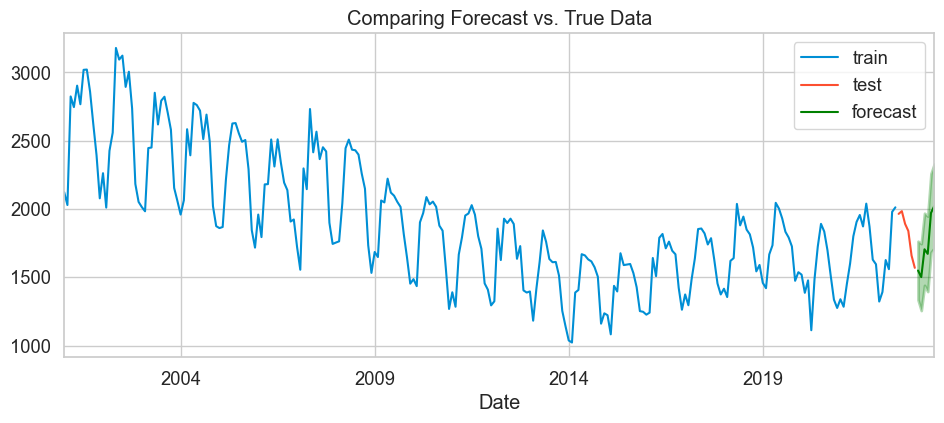

In [100]:
# Obtain future forecasts beyond test data
assault_forecast_df  = assault_final_model.get_forecast(len(assault_test)).summary_frame()
plot_forecast(assault_train,assault_test,assault_forecast_df);

### Answer the following questions:

* Calculate the predicted net change in the number (raw counts) of this type of crime from the beginning of the forecast to the end.
* Convert the raw delta into a percent change.

In [101]:
# view the starting and ending dates of our forecast
assault_forecast_df.index[0],assault_forecast_df.index[-1]

(Timestamp('2023-01-31 00:00:00'), Timestamp('2023-06-30 00:00:00'))

In [102]:
# Defining the starting count
assault_starting_count = assault_forecast_df['mean'].iloc[0]
assault_starting_count

1549.1437238531148

In [103]:
# Defining the final count
assault_final_count = assault_forecast_df['mean'].iloc[-1]
assault_final_count

2020.5571947463823

In [104]:
# Calculate the net change in the number of Assault crimes
assault_net_change = assault_final_count - assault_starting_count
assault_net_change

471.41347089326746

In [105]:
# Calculate the percent change
assault_percent_change = (assault_net_change / assault_starting_count) * 100
assault_percent_change

30.430583272205507

In [106]:
print(f'Predicted net change in number of Assault crimes: {assault_net_change:,.2f}')

Predicted net change in number of Assault crimes: 471.41


In [107]:
print(f'Percent change in number of Assault crimes: {assault_percent_change:.2f}%')

Percent change in number of Assault crimes: 30.43%


## Final Evaluation:
After completing both models and getting the forecasts for both crimes for 6 months into the future (beyond the data), answer the following questions:

* Of the two crimes, which is forecasted to have the highest monthly count of crimes at the end of the forecast?
* Of the two crimes, which is forecasted to have the highest net change by the end of the forecast?
* Of the two crimes, which is forecasted to have the highest percent change by the end of the forecast?

In [109]:
# Highest monthly count at the end of the forecast
highest_monthly_count = 'Theft' if theft_final_count > assault_final_count else 'Assault'

print(f"Highest Monthly Count at End of Forecast: {highest_monthly_count}")

Highest Monthly Count at End of Forecast: Theft


In [110]:
# Highest net change by the end of the forecast
highest_net_change = 'Theft' if abs(theft_net_change) > abs(assault_net_change) else 'Assault'

print(f"Highest Net Change by End of Forecast: {highest_net_change}")

Highest Net Change by End of Forecast: Theft


In [111]:
# Highest percent change by the end of the forecast
highest_percent_change = 'Theft' if theft_percent_change > assault_percent_change else 'Assault'

print(f"Highest Percent Change by End of Forecast: {highest_percent_change}")

Highest Percent Change by End of Forecast: Assault


## Final Recommendations

* What recommendation would you make to the stakeholders?
* Include reporting-quality visual(s) to support your recommendation.

### Recommendations to Stakeholders:

#### 1. Focus on Theft Prevention: 
Since Theft is forecasted to have the highest monthly count and net change by the end of the forecast period, stakeholders should prioritize resources towards preventing Theft. This could involve community outreach programs, increasing police patrols in high-theft areas, and public awareness campaigns about theft prevention measures.

#### 2. Address the Rising Trend in Assault: 
Despite the lower raw count, the percent change for Assault is forecasted to be higher than for Theft, indicating a faster relative increase. It would be prudent to investigate the underlying causes for this rise and develop targeted interventions to address them, such as violence prevention initiatives and conflict resolution education.

#### 3. Monitor and Evaluate: 
Continuous monitoring of crime trends is essential. Implement an evaluation framework that tracks the effectiveness of the interventions over time and allows for adjustments based on real-time data.

#### 4. Community Engagement: 
Engage with local communities to understand their concerns and insights regarding both Theft and Assault. Community-based strategies can be more effective when they incorporate input from those directly affected.

#### 5. Resource Allocation: 
Allocate resources dynamically, with the ability to respond to the changing landscape of crime rates. As Assault rates are rising at a potentially faster percentage rate, it might signal emerging hotspots or trends that require immediate attention.

### Supporting Visuals:

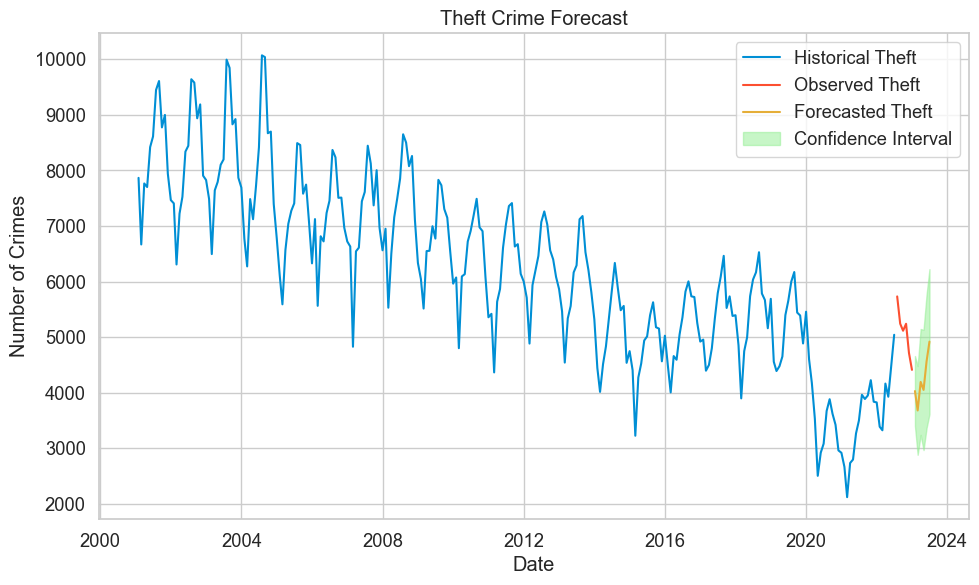

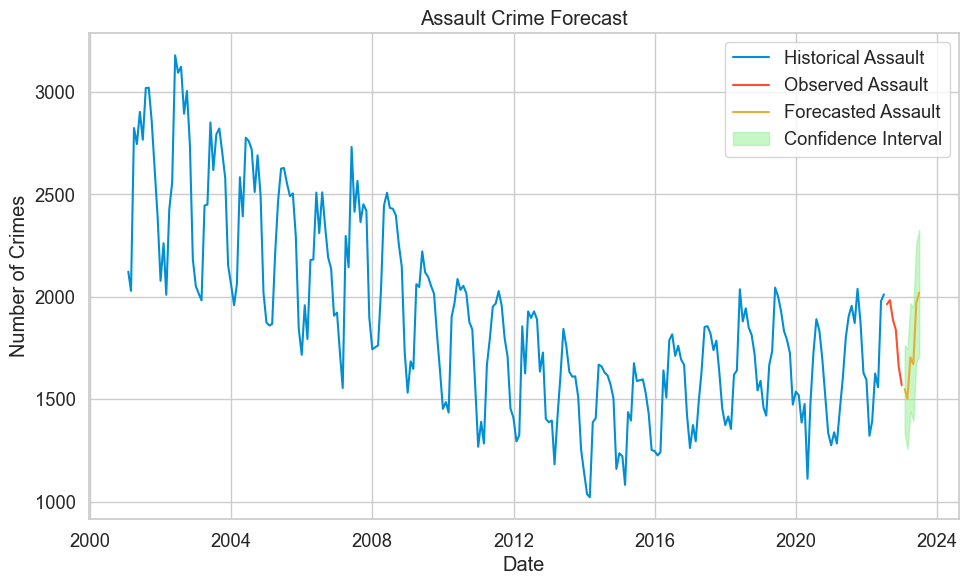

In [114]:
import matplotlib.dates as mdates

# Plot historical and forecast data for Theft
plt.figure(figsize=(10, 6))
plt.plot(theft_train.index, theft_train, label='Historical Theft')
plt.plot(theft_test.index, theft_test, label='Observed Theft')
plt.plot(theft_forecast_df.index, theft_forecast_df['mean'], label='Forecasted Theft')
plt.fill_between(theft_forecast_df.index,
                 theft_forecast_df['mean_ci_lower'],
                 theft_forecast_df['mean_ci_upper'], color='lightgreen', alpha=0.5,
                 label='Confidence Interval')
plt.title('Theft Crime Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()

# Plot historical and forecast data for Assault
plt.figure(figsize=(10, 6))
plt.plot(assault_train.index, assault_train, label='Historical Assault')
plt.plot(assault_test.index, assault_test, label='Observed Assault')
plt.plot(assault_forecast_df.index, assault_forecast_df['mean'], label='Forecasted Assault')
plt.fill_between(assault_forecast_df.index,
                 assault_forecast_df['mean_ci_lower'],
                 assault_forecast_df['mean_ci_upper'], color='lightgreen', alpha=0.5,
                 label='Confidence Interval')
plt.title('Assault Crime Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()